## Introduction

This kernels uses the recent pip wheel of DALI for decoding dicoms using GPU. It works for all JPEG2000 and most of the JPEG-lossless formated images.

The decoding work strongly is based on the kernels of Theo Viel (@theoviel) and David Austin (@tivfrvqhs5)

***WARNING***: Allthough the GPU decoding works for all train images, a few of the JPEG-lossless formated DICOMS (TransferSyntaxUID == '1.2.840.10008.1.2.4.70') of the hidden test set cannot be decoded. So its crucial to have a CPU fallback in place so the notebook wont throw an exception in the submission re-run

## Requirements

We start with installing pip requirements.

In [1]:
!pip install -q timm==0.6.5 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q albumentations==1.2.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q pylibjpeg-libjpeg==1.3.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
# !pip install -q pydicom==2.0.0 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q python-gdcm==3.0.20 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements
!pip install -q dicomsdl==0.109.1 --no-index --find-links=/kaggle/input/rsna-bc-pip-requirements

Then we install the latest DALI packaging which we will use for GPU decoding

In [2]:
# !pip install -q /kaggle/input/nvidia-dali-nightly-cuda110-1230dev/nvidia_dali_nightly_cuda110-1.23.0.dev20230203-7187866-py3-none-manylinux2014_x86_64.whl

Next, we import all the packages we need and patch a function to allow for INT16 support

In [3]:
import timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from copy import copy
import gc
import shutil 
from matplotlib import pyplot as plt

import glob
from scipy.special import expit

import albumentations as A
import cv2
cv2.setNumThreads(0)

import dicomsdl
import pydicom
from pydicom.filebase import DicomBytesIO

from os.path import join

from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing as mp

from types import SimpleNamespace
from typing import Any, Dict

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast


# import nvidia.dali.fn as fn
# import nvidia.dali.types as types
# from nvidia.dali import pipeline_def
# from nvidia.dali.types import DALIDataType

In [4]:
# #we need to patch DALI for Int16 support


# from nvidia.dali.backend import TensorGPU, TensorListGPU
# from nvidia.dali.pipeline import Pipeline
# import nvidia.dali.ops as ops
# from nvidia.dali import types
# from nvidia.dali.plugin.base_iterator import _DaliBaseIterator
# from nvidia.dali.plugin.base_iterator import LastBatchPolicy
# import torch
# import torch.utils.dlpack as torch_dlpack
# import ctypes
# import numpy as np
# import torch.nn.functional as F
# import pydicom

# to_torch_type = {
#     types.DALIDataType.FLOAT:   torch.float32,
#     types.DALIDataType.FLOAT64: torch.float64,
#     types.DALIDataType.FLOAT16: torch.float16,
#     types.DALIDataType.UINT8:   torch.uint8,
#     types.DALIDataType.INT8:    torch.int8,
#     types.DALIDataType.UINT16:  torch.int16,
#     types.DALIDataType.INT16:   torch.int16,
#     types.DALIDataType.INT32:   torch.int32,
#     types.DALIDataType.INT64:   torch.int64
# }


# def feed_ndarray(dali_tensor, arr, cuda_stream=None):
#     """
#     Copy contents of DALI tensor to PyTorch's Tensor.

#     Parameters
#     ----------
#     `dali_tensor` : nvidia.dali.backend.TensorCPU or nvidia.dali.backend.TensorGPU
#                     Tensor from which to copy
#     `arr` : torch.Tensor
#             Destination of the copy
#     `cuda_stream` : torch.cuda.Stream, cudaStream_t or any value that can be cast to cudaStream_t.
#                     CUDA stream to be used for the copy
#                     (if not provided, an internal user stream will be selected)
#                     In most cases, using pytorch's current stream is expected (for example,
#                     if we are copying to a tensor allocated with torch.zeros(...))
#     """
#     dali_type = to_torch_type[dali_tensor.dtype]

#     assert dali_type == arr.dtype, ("The element type of DALI Tensor/TensorList"
#                                     " doesn't match the element type of the target PyTorch Tensor: "
#                                     "{} vs {}".format(dali_type, arr.dtype))
#     assert dali_tensor.shape() == list(arr.size()), \
#         ("Shapes do not match: DALI tensor has size {0}, but PyTorch Tensor has size {1}".
#             format(dali_tensor.shape(), list(arr.size())))
#     cuda_stream = types._raw_cuda_stream(cuda_stream)

#     # turn raw int to a c void pointer
#     c_type_pointer = ctypes.c_void_p(arr.data_ptr())
#     if isinstance(dali_tensor, (TensorGPU, TensorListGPU)):
#         stream = None if cuda_stream is None else ctypes.c_void_p(cuda_stream)
#         dali_tensor.copy_to_external(c_type_pointer, stream, non_blocking=True)
#     else:
#         dali_tensor.copy_to_external(c_type_pointer)
#     return arr





Next I set major variables which handle the public run and the re-run on the hidden test set, and also allow for simulating the size of the hidden test set by setting RAM_CHECK = True

In [5]:
# Params

COMP_FOLDER = '/kaggle/input/rsna-breast-cancer-detection/'
DATA_FOLDER = COMP_FOLDER + 'test_images/'

sample_submission = pd.read_csv(COMP_FOLDER + 'sample_submission.csv')

PUBLIC_RUN = len(sample_submission) == 2

N_CORES = mp.cpu_count()
MIXED_PRECISION = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

RAM_CHECK = True
DEBUG = False

test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
test_df['cancer'] = 0 #dummy value


# if PUBLIC_RUN is False:
#     RAM_CHECK = False
#     DEBUG = False

if RAM_CHECK is True:
    test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')[:10]
    
    print(test_df.shape)


    patient_filter = list(sorted((set(test_df.patient_id.unique()))))
    test_df = test_df[test_df.patient_id.isin(patient_filter)]
    DATA_FOLDER = DATA_FOLDER.replace('test','train')

if DEBUG is True:
    test_df = test_df.head(500)

test_df

(10, 14)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
5,2,10011,270344397,L,MLO,55.0,0,0,0,0.0,0,NaN,21,True
6,2,10011,541722628,R,CC,55.0,0,0,0,NaN,0,NaN,21,False
7,2,10011,1031443799,R,MLO,55.0,0,0,0,NaN,0,NaN,21,False
8,2,10025,562340703,L,CC,75.0,0,0,0,NaN,0,NaN,29,False
9,2,10025,1365269360,L,MLO,75.0,0,0,0,NaN,0,NaN,29,False


In [6]:
print(f'Len df : {len(test_df)}')
test_df['patient_id'].nunique()

Len df : 10


3

In [7]:
test_df["fns"] = test_df['patient_id'].astype(str) + '/' + test_df['image_id'].astype(str) + '.dcm'

Next, we define the function for GPU-based decoding using DALI and processing the dicom images

In [8]:
# def convert_dicom_to_jpg(file, save_folder=""):
#     patient = file.split('/')[-2]
#     image = file.split('/')[-1][:-4]
#     dcmfile = pydicom.dcmread(file)

#     if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':
#         with open(file, 'rb') as fp:
#             raw = DicomBytesIO(fp.read())
#             ds = pydicom.dcmread(raw)
#         offset = ds.PixelData.find(b"\x00\x00\x00\x0C")  #<---- the jpeg2000 header info we're looking for
#         hackedbitstream = bytearray()
#         hackedbitstream.extend(ds.PixelData[offset:])
#         with open(save_folder + f"{patient}_{image}.jpg", "wb") as binary_file:
#             binary_file.write(hackedbitstream)
            
#     if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.70':
#         with open(file, 'rb') as fp:
#             raw = DicomBytesIO(fp.read())
#             ds = pydicom.dcmread(raw)
#         offset = ds.PixelData.find(b"\xff\xd8\xff\xe0")  #<---- the jpeg lossless header info we're looking for
#         hackedbitstream = bytearray()
#         hackedbitstream.extend(ds.PixelData[offset:])
#         with open(save_folder + f"{patient}_{image}.jpg", "wb") as binary_file:
#             binary_file.write(hackedbitstream)

            
# @pipeline_def
# def jpg_decode_pipeline(jpgfiles):
#     jpegs, _ = fn.readers.file(files=jpgfiles)
#     images = fn.experimental.decoders.image(jpegs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16)
#     return images

# def parse_window_element(elem):
#     if type(elem)==list:
#         return float(elem[0])
#     if type(elem)==str:
#         return float(elem)
#     if type(elem)==float:
#         return elem
#     if type(elem)==pydicom.dataelem.DataElement:
#         try:
#             return float(elem[0])
#         except:
#             return float(elem.value)
#     return None

# def linear_window(data, center, width):
#     lower, upper = center - width // 2, center + width // 2
#     data = torch.clamp(data, min=lower, max=upper)
#     return data 

# def process_dicom(img, dicom):
#     try:
#         invert = getattr(dicom, "PhotometricInterpretation", None) == "MONOCHROME1"
#     except:
#         invert = False
        
#     center = parse_window_element(dicom["WindowCenter"]) 
#     width = parse_window_element(dicom["WindowWidth"])
        
#     if (center is not None) & (width is not None):
#         img = linear_window(img, center, width)

#     img = (img - img.min()) / (img.max() - img.min())
#     if invert:
#         img = 1 - img
#     return img

In [9]:
cfg = SimpleNamespace(**{})
cfg.img_size = 1024
cfg.backbone = 'seresnext50_32x4d'
cfg.pretrained=False
cfg.in_channels = 1
cfg.classes = ['cancer']
cfg.batch_size = 8
cfg.data_folder = "/tmp/output/"
cfg.val_aug = A.CenterCrop(always_apply=False, p=1.0, height=cfg.img_size, width=cfg.img_size)
cfg.device = DEVICE

We will process the dicoms in chunks so the disk space does not become an issue. 

In [10]:
SAVE_FOLDER = cfg.data_folder
# SAVE_FOLDER = '/kaggle/working/pngs/'
!mkdir {SAVE_FOLDER}

In [11]:
JPG_FOLDER = "/tmp/jpg/"
# JPG_FOLDER = '/kaggle/working/jpg/'
!mkdir {JPG_FOLDER}

In [12]:
SAVE_SIZE = int(cfg.img_size * 1.125)
# SAVE_FOLDER = cfg.data_folder
os.makedirs(SAVE_FOLDER, exist_ok=True)
N_CHUNKS = len(test_df["fns"]) // 2000 if len(test_df["fns"]) > 2000 else 1
CHUNKS = [(len(test_df["fns"]) / N_CHUNKS * k, len(test_df["fns"]) / N_CHUNKS * (k + 1)) for k in range(N_CHUNKS)]
CHUNKS = np.array(CHUNKS).astype(int)


In [13]:
SAVE_FOLDER = '/kaggle/input/rsna-1024x1024-pngs-small/pngs'

In [14]:


# for ttt, chunk in enumerate(CHUNKS):
#     print(f'chunk {ttt} of {len(CHUNKS)} chunks')
#     os.makedirs(JPG_FOLDER, exist_ok=True)

#     _ = Parallel(n_jobs=2)(
#         delayed(convert_dicom_to_jpg)(f'{DATA_FOLDER}/{img}', save_folder=JPG_FOLDER)
#         for img in test_df["fns"].tolist()[chunk[0]: chunk[1]]
#     )
    
#     jpgfiles = glob.glob(JPG_FOLDER + "*.jpg")


#     pipe = jpg_decode_pipeline(jpgfiles, batch_size=1, num_threads=2, device_id=0)
#     pipe.build()

#     for i, f in enumerate(tqdm(jpgfiles)):
        
#         patient, dicom_id = f.split('/')[-1][:-4].split('_')
#         dicom = pydicom.dcmread(DATA_FOLDER + f"/{patient}/{dicom_id}.dcm")
#         try:
#             out = pipe.run()
#             # Dali -> Torch
#             img = out[0][0]
#             img_torch = torch.empty(img.shape(), dtype=torch.int16, device="cuda")
#             feed_ndarray(img, img_torch, cuda_stream=torch.cuda.current_stream(device=0))
#             img = img_torch.float()

            


#             #apply dicom preprocessing
#             img = process_dicom(img, dicom)

#             #resize the torch image
#             img = F.interpolate(img.view(1, 1, img.size(0), img.size(1)), (SAVE_SIZE, SAVE_SIZE), mode="bilinear")[0, 0]

#             img = (img * 255).clip(0,255).to(torch.uint8).cpu().numpy()
#             out_file_name = SAVE_FOLDER + f"{patient}_{dicom_id}.png"
#             cv2.imwrite(out_file_name, img)
    
#         except Exception as e:
#             print(i, e)
#             pipe = jpg_decode_pipeline(jpgfiles[i+1:], batch_size=1, num_threads=2, device_id=0)
#             pipe.build()
#             continue

#     shutil.rmtree(JPG_FOLDER)
# print(f'DALI Raw image load complete')

In [15]:
fns = glob.glob(f'{SAVE_FOLDER}/*.png')
n_saved = len(fns)
print(f'Image on disk count : {n_saved}')

Image on disk count : 54706


In [16]:
fns = glob.glob(f'{JPG_FOLDER}/*.jpg')
n_saved = len(fns)
print(f'Image on disk count : {n_saved}')

Image on disk count : 0


A few hidden test set images might not be decoded via DALI, so we fallback to CPU for those

In [17]:
# gpu_processed_files = [fn.split('/')[-1].replace('_','/').replace('png','dcm') for fn in fns]
# to_process = [f for f in test_df["fns"].values if f not in gpu_processed_files]
# len(gpu_processed_files), len(to_process)

In [18]:

def process(f, save_folder=""):
    patient = f.split('/')[-2]
    dicom_id = f.split('/')[-1][:-4]
    
    dicom = dicomsdl.open(f)
    img = dicom.pixelData()
    img = torch.from_numpy(img)
    img = process_dicom(img, dicom)
    
    img = F.interpolate(img.view(1, 1, img.size(0), img.size(1)), (SAVE_SIZE, SAVE_SIZE), mode="bilinear")[0, 0]

    img = (img * 255).clip(0,255).to(torch.uint8).cpu().numpy()
    out_file_name = SAVE_FOLDER + f"{patient}_{dicom_id}.png"
    cv2.imwrite(out_file_name, img)
    return out_file_name

In [19]:
# cpu_processed_filenames = Parallel(n_jobs=2)(
#     delayed(process)(f'{DATA_FOLDER}/{img}', save_folder=SAVE_FOLDER)
#     for img in tqdm(to_process)
# )
# cpu_processed_filenames = [f for f in cpu_processed_filenames if f]
# print(f'CPU Raw image load complete with {len(cpu_processed_filenames)} loaded')

In [20]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
n_saved = len(glob.glob(f'{SAVE_FOLDER}/*.png'))
print(f'Image on disk count : {n_saved}')

Image on disk count : 54706


In [22]:
#this is dicom_reader_v3a.p

###########################################################################################
#from pydicom.pixel_data_handlers.util import apply_voi_lut
from typing import (
    Dict, Optional, Union, List, Tuple, TYPE_CHECKING, cast, Iterable,
    ByteString
)
from pydicom.valuerep import VR

# Binarize the image at the threshold
def _binarize(img, threshold):
    return (img > threshold).astype(np.uint8)

# Get contour points of the breast
def _extract_contour(bin_img):
    contours, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    return contour


# Set to background pixels of the image to zero
def _erase_background(img, contour):
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    output = cv2.bitwise_and(img, mask)
    return output
    
 # Crop the useless background of the image
def img2roi(img):
    
    # Flip T0 Left/Right Orientation
    h0, w0 = img.shape
    if img[:,int(-w0 * 0.10):].sum() > img[:,:int(w0 * 0.10)].sum():
        img = np.flip(img, axis=1)
        
        
    bin_img = _binarize(img, threshold=5)
    contour = _extract_contour(bin_img)
    img = _erase_background(img, contour)
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = int(0.975 * x1), int(1.025 * x2)
    y1, y2 = int(0.975 * y1), int(1.025 * y2)
    
    x_offset = x2#get_x_offset(image, debug=debug)
    offset_bottom, offset_top = y1, y2#get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset - x1
    
    # Pad crop offsets to target aspect ratio
    # Height too large, pad x offset
    if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
#         print('add x')
        x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
    else:
#         print('add y')
        # Height too small, pad bottom/top offsets
        offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
        offset_bottom_correction = max(0, -offset_bottom)
        offset_bottom += offset_bottom_correction

        offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
        offset_top += offset_bottom_correction
        
    # Crop Image
#     image = image[offset_bottom:offset_top:,:x_offset]
    
    return img[offset_bottom:offset_top, x1:x_offset]   

In [23]:
# glob.glob(f'jpg/*')

In [24]:
glob.glob(f'{SAVE_FOLDER}/*')[:10]

['/kaggle/input/rsna-1024x1024-pngs-small/pngs/10289_1390886438.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/21915_1598001440.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/5123_1805049792.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/2821_494034978.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/47058_338044000.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/51675_197596660.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/36714_413497321.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/46319_1004428353.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/49299_1137424604.png',
 '/kaggle/input/rsna-1024x1024-pngs-small/pngs/4356_784715438.png']

In [25]:
imglist = [xx.split('/')[-1].split('.')[0] for xx in glob.glob(f'{SAVE_FOLDER}/*')]

In [34]:
TARGET_HEIGHT_WIDTH_RATIO = 1
SAVE_FOLDER_CROP = '/kaggle/working/pngs/'
!mkdir {SAVE_FOLDER_CROP}



In [35]:
filelist = glob.glob(f'{SAVE_FOLDER}/*.png')
filelist = [xx for xx in filelist if '1942326353' not in xx]


In [36]:
for ii in tqdm(range(len(filelist))):
    try:
        image = cv2.imread(filelist[ii], cv2.IMREAD_GRAYSCALE)
        image = img2roi(image)
        image = cv2.resize(image, (SAVE_SIZE,SAVE_SIZE), interpolation=cv2.INTER_AREA)
        out_file_name = SAVE_FOLDER_CROP + filelist[ii].split('/')[-1]
        saved = cv2.imwrite(out_file_name, image)
    except:
        print('failed name:',filelist[ii])

100%|██████████| 27000/27000 [19:26<00:00, 23.14it/s]


In [37]:
filelist_CROP = glob.glob(f'{SAVE_FOLDER_CROP}/*.png')
filelist_CROP

['/kaggle/working/pngs/32565_969342931.png',
 '/kaggle/working/pngs/51115_365211976.png',
 '/kaggle/working/pngs/21748_1023793728.png',
 '/kaggle/working/pngs/35956_917879637.png',
 '/kaggle/working/pngs/46029_1646861107.png',
 '/kaggle/working/pngs/17507_1509848268.png',
 '/kaggle/working/pngs/26874_1251232554.png',
 '/kaggle/working/pngs/32962_904939481.png',
 '/kaggle/working/pngs/64427_1756461353.png',
 '/kaggle/working/pngs/10486_1788153356.png',
 '/kaggle/working/pngs/48356_1236735685.png',
 '/kaggle/working/pngs/33088_1289869628.png',
 '/kaggle/working/pngs/51702_1043503792.png',
 '/kaggle/working/pngs/57313_1917810465.png',
 '/kaggle/working/pngs/58652_495596095.png',
 '/kaggle/working/pngs/13802_674573088.png',
 '/kaggle/working/pngs/61769_1073026216.png',
 '/kaggle/working/pngs/24239_471715641.png',
 '/kaggle/working/pngs/28308_92358603.png',
 '/kaggle/working/pngs/27008_1476780261.png',
 '/kaggle/working/pngs/26515_1126783567.png',
 '/kaggle/working/pngs/12920_1195556021.png

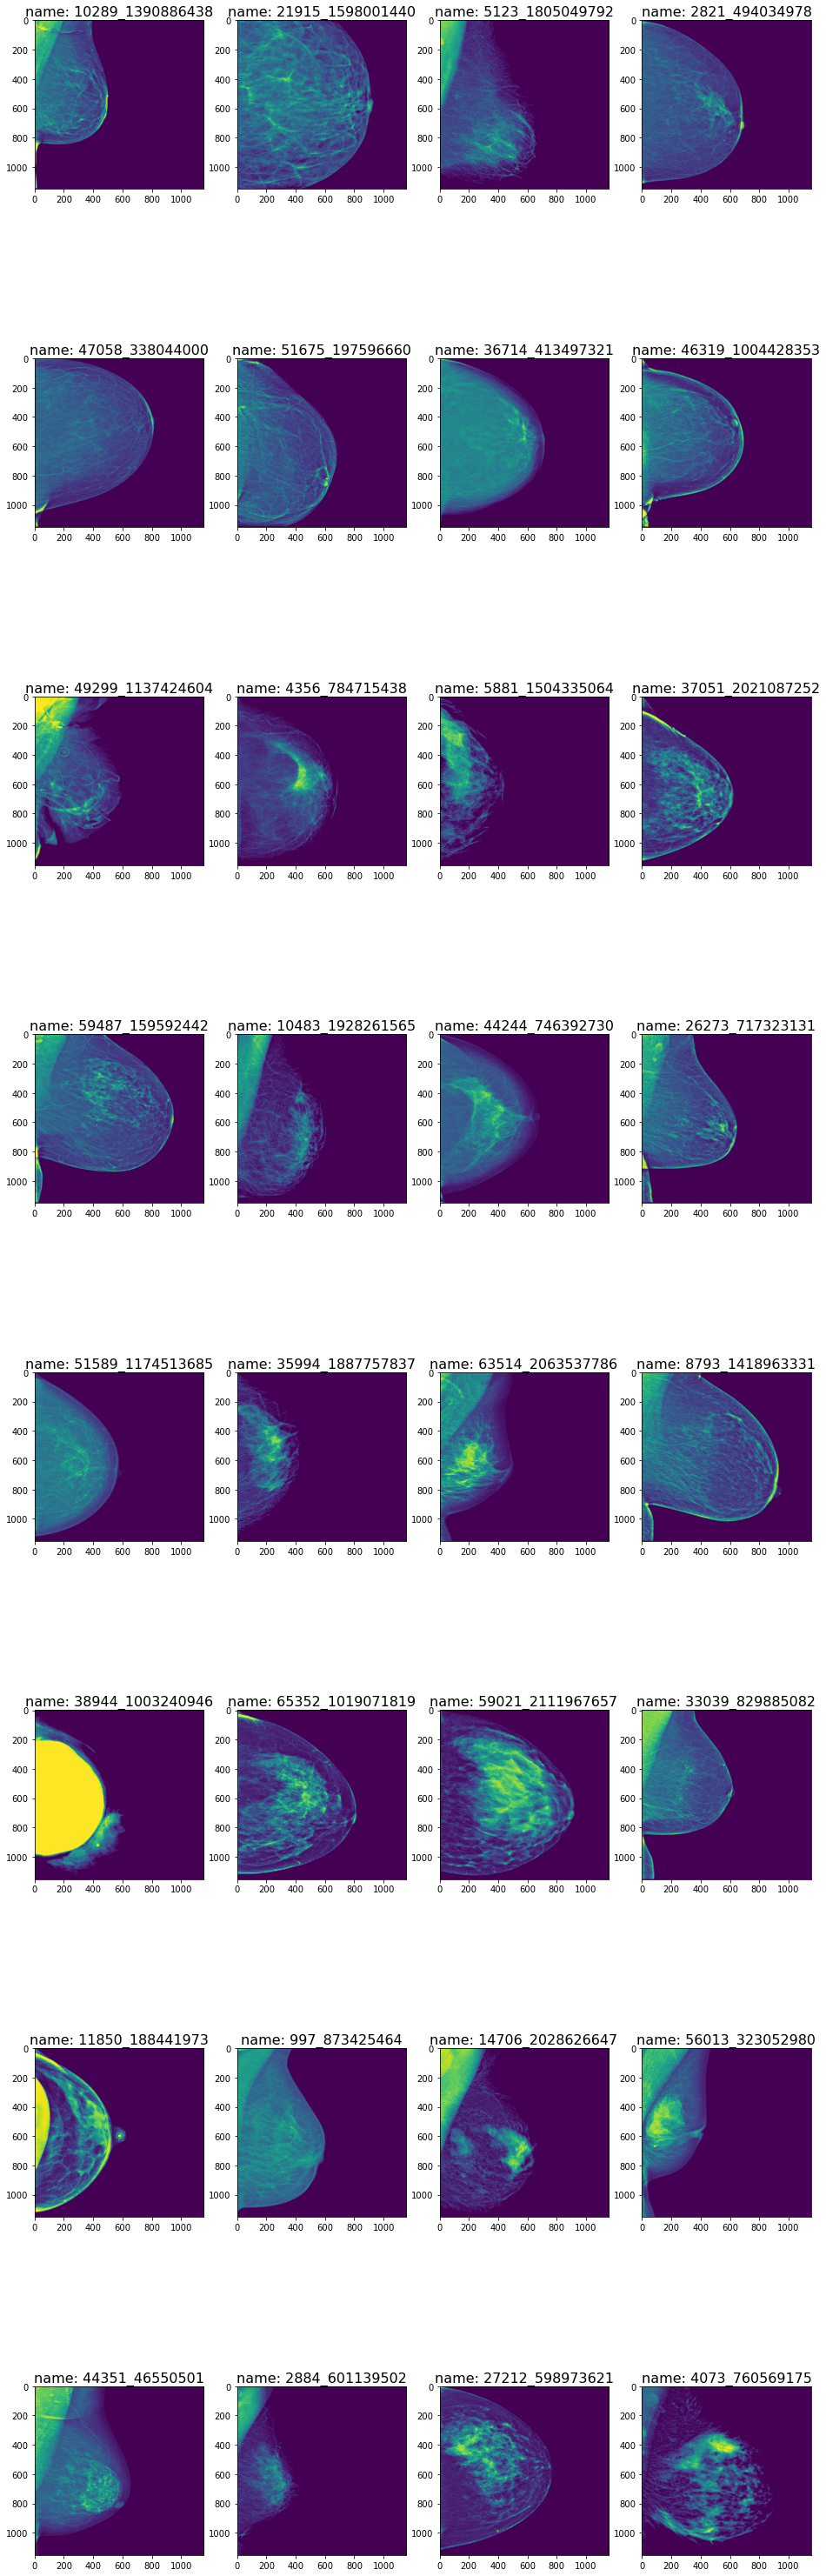

In [38]:
n_rows = 8
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4, n_rows*7))
for r in range(n_rows):
    for c in range(n_cols):
        idx = r * n_cols + c
        # Image
        imagetest = cv2.imread(filelist_CROP[idx], cv2.IMREAD_GRAYSCALE)

        axes[r, c].imshow(imagetest)
        # Target
        name = filelist[idx].split('/')[-1].replace('.png','')
        axes[r, c].set_title(f'name: {name}', fontsize=16, pad=5)
